# 모형선택

* 모형 선택은 주어진 데이터에 대해 가장 적합한 회귀모형을 선택하는 과정이다.

* 현대의 빅데이터 시대에는 모형을 만드는데 있어서 여러가지 고민이 들 수 있다. 

* 예를 들어, 상호작용 변수을 어디서부터 어떻게 추가해야 할지 고민될 수도 있고, 고전적인 선형회귀 뿐만이 아니라 최신 머신러닝 기법을 적용할지에 대한 고민이 많이 들 수 있다. 

* 이럴 때 모형선택이 필요하다. 과적합을 최소화하면서도, 예측력을 극대화하는 과정에 도움을 주기 때문

# 모형선택의 기준

## 1. 결정계수
- **$R^2$**: $R^2$은 결정계수로, 모형이 데이터의 변동성을 얼마나 잘 설명하는지를 나타내는 지표다. 

- 0에서 1 사이의 값을 가지며, 값이 클수록 모형이 데이터를 잘 설명한다고 해석된다. 

- 그러나 $R^2$ 값은 독립 변수의 수가 증가하면 자연스럽게 커지는 경향이 있어, 단순히 $R^2$ 값만으로 모형의 적합도를 판단하는 것은 한계가 있다.
  
- **조정된 $R^2$** : 조정된 $R^2$은 $R^2$의 단점을 보완한 지표로, 독립 변수의 개수를 고려하여 조정된 값이다. 

- 조정된 $R^2$은 독립 변수의 개수가 증가해도 과도한 상승을 억제하며, 모형의 복잡도와 설명력을 균형 있게 평가한다.

$$
\text{Adjusted } R^2 = 1 - \left( \frac{(1-R^2)(n-1)}{n-p-1} \right)
$$

여기서 $n$은 데이터 포인트 수, $p$는 독립 변수의 수이다.


## 2. Mallows' Cp

Mallows' Cp는 모형의 편향과 분산 사이의 균형을 평가하기 위해 사용되는 지표다. 주어진 모형의 Cp 값이 독립 변수의 수와 비슷하거나 작다면, 그 모형은 데이터에 대해 적절한 설명력을 갖춘 것으로 간주될 수 있다. Cp 값이 낮을수록 모형이 좋다고 평가된다.

$$
\text{Cp} = \frac{\text{RSS}}{\sigma^2} + 2p - n
$$

여기서 \(\text{RSS}\)는 잔차제곱합, \(\sigma^2\)는 오차의 분산, \(p\)는 모형의 파라미터 수, \(n\)은 데이터 포인트 수다.



## 3. Stepwise 방법과 AIC / BIC

- **Stepwise**: Stepwise 방법은 변수 선택의 자동화된 방법으로, 변수를 하나씩 추가하거나 제거하면서 최적의 모형을 찾는다. 이 과정에서 모형의 적합도를 평가하기 위해 AIC(Akaike Information Criterion)나 BIC(Bayesian Information Criterion)를 사용한다.

- **AIC**: AIC는 모형의 적합도와 복잡도 사이의 균형을 평가하는 지표다. 값이 낮을수록 모형의 적합도가 높고, 불필요하게 복잡하지 않음을 의미한다.

$$
\text{AIC} = 2p - 2\ln(L)
$$

여기서 \(p\)는 파라미터 수, \(L\)은 최대우도함수(Maximum Likelihood) 값이다.

- **BIC**: BIC는 AIC와 유사하지만, 모델에 포함된 변수의 수에 대한 패널티가 더 강하게 적용된다. 데이터 포인트 수가 많아질수록 BIC는 더 큰 패널티를 부과하며, 단순한 모델을 선호한다.

$$
\text{BIC} = \ln(n)p - 2\ln(L)
$$

여기서 \(n\)은 데이터 포인트 수이다.

## 4. 교차검증 (Cross-Validation)

교차검증은 데이터셋을 여러 부분으로 나누어, 각 부분을 검증 데이터로 사용해 모형의 성능을 평가하는 방법이다. 

일반적으로 k-폴드 교차검증을 많이 사용한다.

데이터셋을 k개의 부분으로 나눈 후, 각 부분을 검증 데이터로 사용하고 나머지 부분을 훈련 데이터로 사용해 모델을 학습시킨다. 

모든 k개의 폴드에 대해 모형을 평가하고 평균을 내어 모형의 일반화 성능을 추정한다. 

교차검증은 특히 데이터가 적은 경우나 과적합을 방지하고자 할 때 유용하다.

# 예제코드

In [2]:
import platform
import matplotlib as mat
import ssl

if platform.system() == 'Darwin':
    mat.rc('font', family='AppleGothic')
    mat.rcParams['axes.unicode_minus'] = False

ssl._create_default_https_context = ssl._create_unverified_context

In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from itertools import combinations
import matplotlib.pyplot as plt

## 1. 데이터 불러오기

In [27]:
# 데이터 불러오기
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
y = pd.Series(california.target, name='PRICE')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 2. 조합의 생성

In [35]:
# 선택된 상호작용 항 생성
def create_selected_interaction_terms(X, selected_pairs):
    interaction_terms = pd.DataFrame(index=X.index)
    for (col1, col2) in selected_pairs:
        interaction_terms[f'{col1}:{col2}'] = X[col1] * X[col2]
    return pd.concat([X, interaction_terms], axis=1)

# 예를 들어 이 두 변수의 상호작용을 추가
selected_pairs = [
    ('MedInc', 'AveOccup'), 
    ('HouseAge', 'AveRooms'), 
    ('AveRooms', 'AveOccup'),
    ('MedInc', 'HouseAge')
]

X_train_interactions = create_selected_interaction_terms(X_train, selected_pairs)
X_test_interactions = create_selected_interaction_terms(X_test, selected_pairs)

## 3. 결정계수로 변수 선택

In [36]:
def select_best_r2_adj_r2(X, y):
    best_r2 = -np.inf
    best_r2_adj = -np.inf
    for k in range(1, len(X.columns) + 1):
        for combo in combinations(X.columns, k):
            X_combo = sm.add_constant(X[list(combo)])
            model = sm.OLS(y, X_combo).fit()
            if model.rsquared > best_r2:
                best_r2 = model.rsquared
                best_model_r2 = combo
            if model.rsquared_adj > best_r2_adj:
                best_r2_adj = model.rsquared_adj
                best_model_r2_adj = combo
    return best_model_r2, best_model_r2_adj

best_r2_vars, best_r2_adj_vars = select_best_r2_adj_r2(X_train_interactions, y_train)
print("Best R^2 variables:", best_r2_vars)
print("Best Adjusted R^2 variables:", best_r2_adj_vars)

Best R^2 variables: ('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedInc:AveOccup', 'HouseAge:AveRooms', 'AveRooms:AveOccup', 'MedInc:HouseAge')
Best Adjusted R^2 variables: ('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'MedInc:AveOccup', 'HouseAge:AveRooms', 'AveRooms:AveOccup', 'MedInc:HouseAge')


## 4. Mallow's Cp 이용

In [37]:
# Mallows' Cp 계산
def select_best_mallows_cp(X, y):
    best_cp = np.inf
    n = len(y)
    for k in range(1, len(X.columns) + 1):
        for combo in combinations(X.columns, k):
            X_combo = sm.add_constant(X[list(combo)])
            model = sm.OLS(y, X_combo).fit()
            cp = (model.ssr / model.mse_resid) + 2 * len(model.params) - n
            if cp < best_cp:
                best_cp = cp
                best_model_cp = combo
    return best_model_cp

best_cp_vars = select_best_mallows_cp(X_train_interactions, y_train)
print("Best Mallows' Cp variables:", best_cp_vars)

Best Mallows' Cp variables: ('MedInc',)


## 5. stepwise 이용

In [39]:
def stepwise_selection(X, y, criterion='AIC'):
    included = []
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.aic if criterion == 'AIC' else model.bic
        best_pval = new_pval.min()
        if best_pval < 0.01:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        worst_pval = model.pvalues.iloc[1:].max()  # p-value of the worst variable
        if worst_pval > 0.05:
            worst_feature = model.pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
        if not changed:
            break
    return included

best_aic_vars = stepwise_selection(X_train_interactions, y_train, criterion='AIC')
best_bic_vars = stepwise_selection(X_train_interactions, y_train, criterion='BIC')
print("Best AIC variables:", best_aic_vars)
print("Best BIC variables:", best_bic_vars)

Best AIC variables: []
Best BIC variables: []


## 6. Cross-Validation 이용

In [40]:
def select_best_cv(X, y):
    best_mse = np.inf
    best_model_cv = None
    cv = KFold(n_splits=10, random_state=42, shuffle=True)
    model = LinearRegression()
    for k in range(1, len(X.columns) + 1):
        for combo in combinations(X.columns, k):
            X_combo = X[list(combo)]
            mse = -np.mean(cross_val_score(model, X_combo, y, scoring='neg_mean_squared_error', cv=cv))
            if mse < best_mse:
                best_mse = mse
                best_model_cv = combo
    return best_model_cv

best_cv_vars = select_best_cv(X_train_interactions, y_train)
print("Best Cross-Validation variables:", best_cv_vars)

Best Cross-Validation variables: ('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude', 'MedInc:HouseAge')


## 7. 최종선택

In [41]:
final_model = sm.OLS(y_train, sm.add_constant(X_train_interactions[list(best_r2_adj_vars)])).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     2082.
Date:                Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                        13:33:35   Log-Likelihood:                -15748.
No. Observations:               14448   AIC:                         3.152e+04
Df Residuals:                   14436   BIC:                         3.161e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -37.0172      0.78

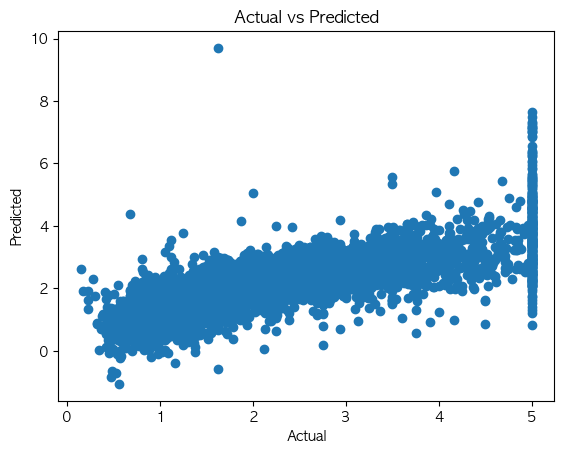

In [42]:
plt.scatter(y_test, final_model.predict(sm.add_constant(X_test_interactions[list(best_r2_adj_vars)])))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()